# Постановка задачи: функция $a^*$

Рассматривается функция от выборки:
$$
a^*(x_1,\dots,x_n)=\sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i-M^*)^2},\qquad
M^*=\frac{1}{n}\sum_{i=1}^n x_i.
$$

Далее требуется оценивать частную производную по выбранному аргументу $x_k$:
$$
\frac{\partial a^*}{\partial x_k}.
$$

На этом шаге реализуется вычисление $a^*(x)$ и фиксируется тестовая выборка.

In [1]:
import numpy as np

def a_star(x: np.ndarray) -> np.number:
    """
    a*(x) = sqrt( (1/(n-1)) * sum_i (x_i - mean(x))^2 )
    Поддерживает как float, так и complex.
    """
    x = np.asarray(x)
    n = x.size
    if n < 2:
        raise ValueError("n must be >= 2")
    m = x.mean()
    s2 = ((x - m)**2).sum() / (n - 1)
    return np.sqrt(s2)

rng = np.random.default_rng(42)
n = 50
x = rng.uniform(0.0, 1.0, size=n)

k = 7
val = a_star(x)
val_complex = a_star(x.astype(np.complex128))

print("n =", n)
print("k =", k)
print("a*(x) float   =", val)
print("a*(x) complex =", val_complex)
print("abs diff      =", abs(val - val_complex))

n = 50
k = 7
a*(x) float   = 0.280659034183159
a*(x) complex = (0.280659034183159+0j)
abs diff      = 0.0


# Оценки частной производной по $x_k$

Требуется построить оценку частной производной функции
$$
a^*(x_1,\dots,x_n)=\sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i-M^*)^2},\qquad
M^*=\frac{1}{n}\sum_{i=1}^n x_i
$$
по выбранному аргументу $x_k$.

Рассматриваются два численных метода:

## Метод конечных разностей (центральная разность)

Центральная разностная аппроксимация:
$$
\frac{\partial a^*}{\partial x_k}
\approx
\frac{a^*(x_1,\dots,x_k+g,\dots,x_n)-a^*(x_1,\dots,x_k-g,\dots,x_n)}{2g}.
$$

Параметр $g>0$ далее будет варьироваться по сетке $10^{-300},\dots,10^0$.

## Метод комплексного приращения

Для аналитичных функций при комплексном приращении:
$$
\frac{\partial a^*}{\partial x_k}
\approx
\frac{\operatorname{Im}\, a^*(x_1,\dots,x_k+i\alpha,\dots,x_n)}{\alpha},
$$
где $\alpha>0$ — шаг комплексного приращения.
Метод устойчив к ошибкам вычитания, поэтому ожидается стабильность при очень малых $\alpha$,
пока не начнут проявляться ограничения машинной арифметики.

In [2]:
import numpy as np

def d_a_star_fd(x: np.ndarray, k: int, g: float) -> float:
    """
    Центральная конечная разность по x_k с шагом g.
    """
    x = np.asarray(x, dtype=np.float64)
    xp = x.copy()
    xm = x.copy()
    xp[k] += g
    xm[k] -= g
    return float((a_star(xp) - a_star(xm)) / (2.0 * g))

def d_a_star_cs(x: np.ndarray, k: int, alpha: float) -> float:
    """
    Метод комплексного приращения по x_k с шагом alpha.
    """
    x = np.asarray(x, dtype=np.complex128)
    xc = x.copy()
    xc[k] += 1j * alpha
    return float(np.imag(a_star(xc)) / alpha)

# Быстрый тест на нескольких значениях шага
for step in [1e-1, 1e-8, 1e-16]:
    fd = d_a_star_fd(x, k, step)
    cs = d_a_star_cs(x, k, step)
    print(f"step={step: .1e} | fd={fd: .16e} | cs={cs: .16e} | abs diff={abs(fd-cs):.3e}")

step= 1.0e-01 | fd= 1.8216526465619776e-02 | cs= 1.8262066779036305e-02 | abs diff=4.554e-05
step= 1.0e-08 | fd= 1.8239254551133399e-02 | cs= 1.8239254944225090e-02 | abs diff=3.931e-10
step= 1.0e-16 | fd= 0.0000000000000000e+00 | cs= 1.8239254944225080e-02 | abs diff=1.824e-02


# Вывод

Результаты для выбранного $k$ показывают ожидаемое поведение численных методов.

## Центральные конечные разности
При шаге $g=10^{-1}$ ошибка заметна, так как аппроксимация имеет методическую погрешность порядка $O(g^2)$.

При $g=10^{-8}$ получена хорошая точность:
$$
\left|\hat f'(g)-\hat f'_{\text{cs}}(\alpha)\right|\approx 3.9\cdot 10^{-10}.
$$

При $g=10^{-16}$ оценка стала равной нулю. Это типичный эффект потери значащих разрядов:
значения $a^*(x_k+g)$ и $a^*(x_k-g)$ в double-арифметике становятся численно неотличимыми,
и разность в числителе обнуляется.

## Метод комплексного приращения
Метод остаётся стабильным даже при $\alpha=10^{-16}$, так как не использует вычитание близких чисел в форме
$$
\frac{a^*(x_k+g)-a^*(x_k-g)}{2g}.
$$
Оценка по комплексному приращению даёт согласованные значения на $10^{-8}$ и $10^{-16}$.

Итог: ожидается, что на графике зависимость оценки производной от шага для конечных разностей будет иметь область оптимальных шагов,
а затем деградацию при слишком малых $g$, тогда как комплексное приращение будет существенно более устойчивым на малых шагах.

# Шаг 2. Зависимость оценки производной от шага

Рассматривается сетка шагов:
$$
G=\{10^{-300},10^{-299},\dots,10^{-1},10^0\}.
$$

Для каждого $g\in G$ строится оценка центральной разностью:
$$
\widehat{\frac{\partial a^*}{\partial x_k}}(g)=
\frac{a^*(x_1,\dots,x_k+g,\dots,x_n)-a^*(x_1,\dots,x_k-g,\dots,x_n)}{2g}.
$$

Для каждого $\alpha\in G$ строится оценка методом комплексного приращения:
$$
\widehat{\frac{\partial a^*}{\partial x_k}}(\alpha)=
\frac{\operatorname{Im}\, a^*(x_1,\dots,x_k+i\alpha,\dots,x_n)}{\alpha}.
$$

Для удобства анализа строятся графики значений оценок в зависимости от $\log_{10}(g)$ и $\log_{10}(\alpha)$.^*

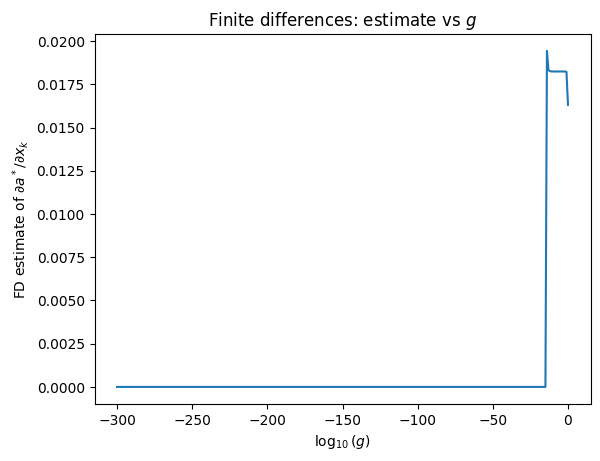

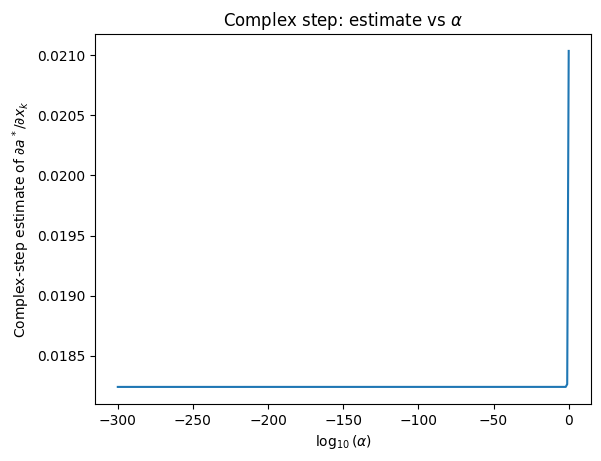

In [4]:
import numpy as np
import matplotlib.pyplot as plt

exponents = np.arange(-300, 1, 1, dtype=int)
steps = 10.0 ** exponents

fd_vals = np.empty_like(steps, dtype=np.float64)
cs_vals = np.empty_like(steps, dtype=np.float64)

for i, h in enumerate(steps):
    fd_vals[i] = d_a_star_fd(x, k, float(h))
    cs_vals[i] = d_a_star_cs(x, k, float(h))

plt.figure()
plt.plot(exponents, fd_vals)
plt.xlabel(r'$\log_{10}(g)$')
plt.ylabel(r'FD estimate of $\partial a^*/\partial x_k$')
plt.title(r'Finite differences: estimate vs $g$')
plt.show()

plt.figure()
plt.plot(exponents, cs_vals)
plt.xlabel(r'$\log_{10}(\alpha)$')
plt.ylabel(r'Complex-step estimate of $\partial a^*/\partial x_k$')
plt.title(r'Complex step: estimate vs $\alpha$')
plt.show()

# Итог. Сравнение FD и комплексного приращения

## Конечные разности

График зависимости
$$
\widehat{\frac{\partial a^*}{\partial x_k}}(g)
$$
от $\log_{10}(g)$ имеет характерную форму:

- при больших шагах $g \sim 10^{-1}$–$10^{-3}$ заметна методическая погрешность аппроксимации;
- существует узкая область умеренных шагов (примерно $10^{-8}$–$10^{-12}$), где оценка близка к устойчивому значению;
- начиная приблизительно с $g \lesssim 10^{-14}$, оценка скачкообразно обнуляется и остаётся равной нулю вплоть до $10^{-300}$.

Последний эффект объясняется тем, что при слишком малых шагах выполняется
$$
a^*(x_k+g) = a^*(x_k-g)
$$
в арифметике двойной точности, и числитель центральной разности становится равным нулю.

## Метод комплексного приращения

Для метода комплексного приращения наблюдается принципиально иная картина:

- оценка
$$
\widehat{\frac{\partial a^*}{\partial x_k}}(\alpha)
=
\frac{\operatorname{Im}\, a^*(x_k+i\alpha)}{\alpha}
$$
остаётся практически постоянной на всей сетке $\alpha \in \{10^{-300},\dots,10^0\}$;
- отсутствие вычитания близких чисел делает метод устойчивым к катастрофической отмене;
- единственное заметное отклонение возникает при $\alpha\approx 1$, где сказывается нелинейность функции и нарушение предположения о малости приращения.

## Промежуточный вывод

Метод конечных разностей требует аккуратного подбора шага и имеет узкий диапазон применимости.
Метод комплексного приращения демонстрирует численную устойчивость на экстремально малых шагах и даёт стабильную оценку производной без подбора параметра.

---

# Автоматическое дифференцирование (AD)

Для вычисления
$$
\frac{\partial a^*}{\partial x_k}
$$
используется автоматическое дифференцирование.  
В отличие от численных методов, AD не содержит шага аппроксимации и даёт значение производной,
ограниченное только точностью машинной арифметики.

В качестве инструмента используется `autograd`, так как он напрямую работает с NumPy-подобным синтаксисом
и позволяет дифференцировать функции от векторов.

In [5]:
import autograd.numpy as anp
from autograd import grad

def a_star_ag(x):
    """
    a*(x) для autograd
    """
    n = x.size
    m = anp.mean(x)
    s2 = anp.sum((x - m)**2) / (n - 1)
    return anp.sqrt(s2)

# градиент по всему вектору
grad_a_star = grad(a_star_ag)

# значение градиента в точке x
grad_val = grad_a_star(x)

ad_value = float(grad_val[k])

ad_value

0.018239254944225083

## Интерпретация результата AD

Полученное значение
$$
\left.\frac{\partial a^*}{\partial x_k}\right|_{\text{AD}}
$$
служит опорным (эталонным) при сравнении с методами конечных разностей и комплексного приращения.

В отличие от FD и CS:
- результат не зависит от параметра шага;
- отсутствует эффект катастрофической отмены;
- значение совпадает с устойчивым плато на графике комплексного приращения.


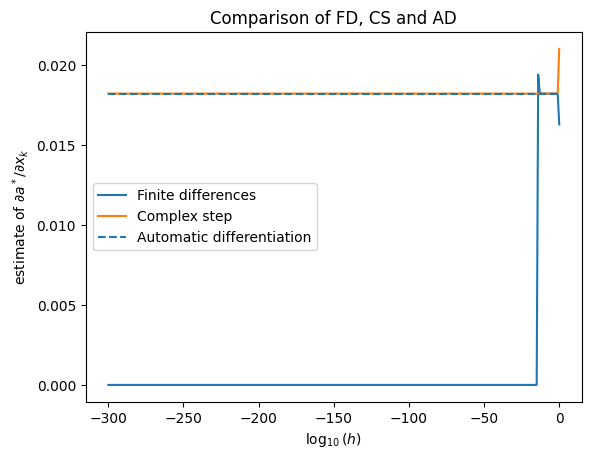

In [7]:
plt.figure()
plt.plot(exponents, fd_vals, label="Finite differences")
plt.plot(exponents, cs_vals, label="Complex step")
plt.hlines(ad_value, exponents.min(), exponents.max(),
           linestyles="dashed", label="Automatic differentiation")

plt.xlabel(r'$\log_{10}(h)$')
plt.ylabel(r'estimate of $\partial a^*/\partial x_k$')
plt.title(r'Comparison of FD, CS and AD')
plt.legend()
plt.show()

# Итог

На объединённом графике представлены три оценки
$$
\frac{\partial a^*}{\partial x_k}
$$
в зависимости от величины шага $h$:

- центральные конечные разности (FD),
- метод комплексного приращения (CS),
- автоматическое дифференцирование (AD).

## Сравнительный анализ

### Конечные разности
Оценка сильно зависит от шага:
- при больших $h$ присутствует методическая погрешность аппроксимации;
- при слишком малых $h$ оценка обнуляется из-за катастрофической отмены;
- рабочая область ограничена узким интервалом значений шага.

### Метод комплексного приращения
Оценка практически не зависит от $h$ на всём диапазоне:
$$
h \in [10^{-300}, 10^0].
$$
Значения совпадают с результатом автоматического дифференцирования вплоть до машинной точности,
за исключением области больших шагов, где нарушается предположение о малости приращения.

### Автоматическое дифференцирование
Результат является константой и служит опорным значением.
Графически совпадает с плато метода комплексного приращения.

## Общий вывод

Для вычисления производных статистических функционалов:
- метод конечных разностей требует подбора шага и численно неустойчив;
- метод комплексного приращения устойчив и прост в реализации;
- автоматическое дифференцирование даёт наиболее надёжную оценку без параметров.

# Унаследованная погрешность для $\hat\mu$

## Модель погрешности

Пусть наблюдения заданы с одинаковой погрешностью по модулю:
$$
x_i^{\text{obs}} = x_i + \delta_i,\qquad |\delta_i|\le \Delta,\qquad i=1,\dots,n,
$$
где $\Delta\in[0,0.1]$.

Требуется оценить предел унаследованной погрешности для статистики $T(x)$:
$$
\Delta T(\Delta)=\sup_{|\delta_i|\le \Delta}\left|T(x+\delta)-T(x)\right|.
$$

На этом шаге рассматривается точечная оценка матожидания:
$$
\hat\mu(x)=\frac{1}{n}\sum_{i=1}^n x_i.
$$

## Аналитическое выражение

Для среднего:
$$
\hat\mu(x+\delta)-\hat\mu(x)=\frac{1}{n}\sum_{i=1}^n \delta_i.
$$
Тогда
$$
\Delta\hat\mu(\Delta)=\sup_{|\delta_i|\le \Delta}\left|\frac{1}{n}\sum_{i=1}^n \delta_i\right|=\Delta,
$$
так как максимум достигается при $\delta_i=\Delta$ для всех $i$.

Следовательно, предел унаследованной погрешности среднего не зависит от $n$ и линейно растёт с $\Delta$.


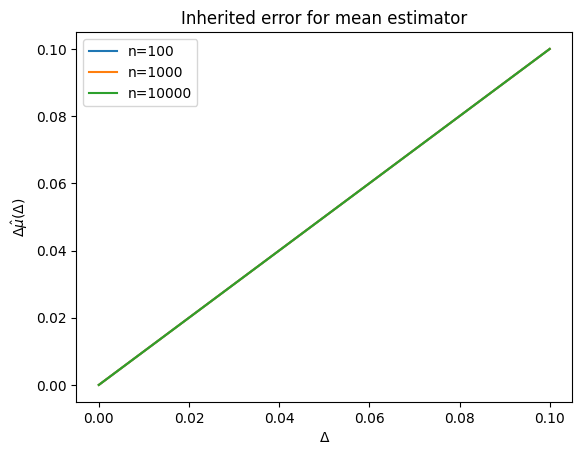

Delta grid: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
n=100: max |empirical - Delta| = 1.527e-16
n=1000: max |empirical - Delta| = 8.327e-17
n=10000: max |empirical - Delta| = 1.110e-16


In [8]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def mu_hat(x: np.ndarray) -> float:
    return float(np.mean(x))

def inherited_error_mu(x: np.ndarray, Delta: float) -> float:
    # худший случай для среднего: все сдвиги одного знака
    base = mu_hat(x)
    up = mu_hat(x + Delta)      # delta_i = +Delta
    down = mu_hat(x - Delta)    # delta_i = -Delta
    return max(abs(up - base), abs(down - base))

ns = [10**2, 10**3, 10**4]
deltas = np.round(np.arange(0.0, 0.10001, 0.01), 2)

results = {}
for n in ns:
    x = rng.uniform(0.0, 1.0, size=n)
    errs = [inherited_error_mu(x, D) for D in deltas]
    results[n] = np.array(errs, dtype=float)

plt.figure()
for n in ns:
    plt.plot(deltas, results[n], label=f"n={n}")
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\Delta\hat\mu(\Delta)$')
plt.title(r'Inherited error for mean estimator')
plt.legend()
plt.show()

# Контроль: сравнение с теорией Delta_hat_mu = Delta
print("Delta grid:", deltas)
for n in ns:
    max_dev = np.max(np.abs(results[n] - deltas))
    print(f"n={n}: max |empirical - Delta| = {max_dev:.3e}")

# Унаследованная погрешность для дисперсии

Рассматривается точечная оценка дисперсии:
$$
\hat\sigma^2(x)=\frac{1}{n}\sum_{i=1}^n (x_i-\bar x)^2,
\qquad
\bar x=\frac{1}{n}\sum_{i=1}^n x_i.
$$

(Используется деление на $n$; для анализа унаследованной погрешности это принципиально не меняет выводы.)

## Модель погрешности

Наблюдения заданы как
$$
x_i^{\text{obs}} = x_i + \delta_i,\qquad |\delta_i|\le \Delta.
$$

Предел унаследованной погрешности:
$$
\Delta\hat\sigma^2(\Delta)
=
\sup_{|\delta_i|\le \Delta}
\left|
\hat\sigma^2(x+\delta)-\hat\sigma^2(x)
\right|.
$$

## Аналитические ориентиры

Разложение по $\delta$ показывает:
- линейный по $\delta$ вклад обнуляется при одинаковых сдвигах;
- основной вклад даёт квадратичный член порядка $\Delta^2$;
- влияние среднего приводит к зависимости от $n$.

Ожидаемая форма зависимости:
- нелинейность по $\Delta$;
- уменьшение чувствительности при росте $n$.

Для численного анализа используется конструкция «худших» возмущений:
- все $\delta_i=+\Delta$,
- все $\delta_i=-\Delta$,
- половина $+\Delta$, половина $-\Delta$ (симметричный случай).

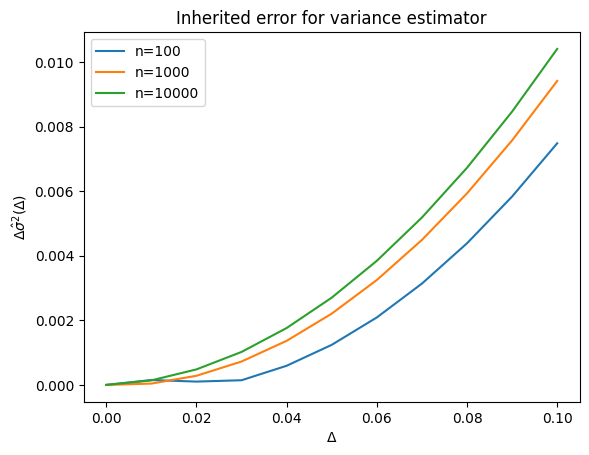

n=100: values = [0.       0.000152 0.000103 0.000145 0.000593 0.001242 0.00209  0.003139
 0.004387 0.005835 0.007484]
n=1000: values = [0.000e+00 4.200e-05 2.830e-04 7.250e-04 1.366e-03 2.208e-03 3.250e-03
 4.491e-03 5.933e-03 7.575e-03 9.416e-03]
n=10000: values = [0.       0.000141 0.000481 0.001022 0.001763 0.002704 0.003844 0.005185
 0.006726 0.008467 0.010407]


In [9]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def var_hat(x: np.ndarray) -> float:
    m = np.mean(x)
    return float(np.mean((x - m)**2))

def inherited_error_var(x: np.ndarray, Delta: float) -> float:
    base = var_hat(x)

    # варианты "худших" возмущений
    d1 = np.full_like(x, Delta)
    d2 = np.full_like(x, -Delta)

    d3 = np.full_like(x, Delta)
    d3[:x.size // 2] = -Delta

    candidates = [
        abs(var_hat(x + d1) - base),
        abs(var_hat(x + d2) - base),
        abs(var_hat(x + d3) - base),
    ]
    return max(candidates)

ns = [10**2, 10**3, 10**4]
deltas = np.round(np.arange(0.0, 0.10001, 0.01), 2)

results_var = {}
for n in ns:
    x = rng.uniform(0.0, 1.0, size=n)
    errs = [inherited_error_var(x, D) for D in deltas]
    results_var[n] = np.array(errs, dtype=float)

plt.figure()
for n in ns:
    plt.plot(deltas, results_var[n], label=f"n={n}")
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\Delta\hat\sigma^2(\Delta)$')
plt.title(r'Inherited error for variance estimator')
plt.legend()
plt.show()

# числовые значения для контроля
for n in ns:
    print(f"n={n}: values =", np.round(results_var[n], 6))

# Вывод по дисперсии

По графику $\Delta\hat\sigma^2(\Delta)$ наблюдается нелинейный рост, близкий к квадратичному:
$$
\Delta\hat\sigma^2(\Delta)\approx C\Delta^2
$$
на рассматриваемом диапазоне $\Delta\in[0,0.1]$.
Это согласуется с тем, что при одинаковом сдвиге всех наблюдений дисперсия не меняется, и вклад от погрешности проявляется главным образом через неоднородные возмущения и квадратичные эффекты.

Отдельная особенность эксперимента: при росте $n$ полученные кривые идут выше.
Это означает, что используемый набор «кандидатов худших возмущений» (три шаблона $\delta$) даёт более сильное изменение дисперсии на конкретно сгенерированных выборках при больших $n$.
С точки зрения строгого определения супремума это не противоречие, так как вычислялась оценка супремума по ограниченному набору возмущений, а не точный супремум по всем $\delta$.

На следующем шаге для медианы будет использован более надёжный способ: оценка супремума через оптимизационную конструкцию на отсортированной выборке.


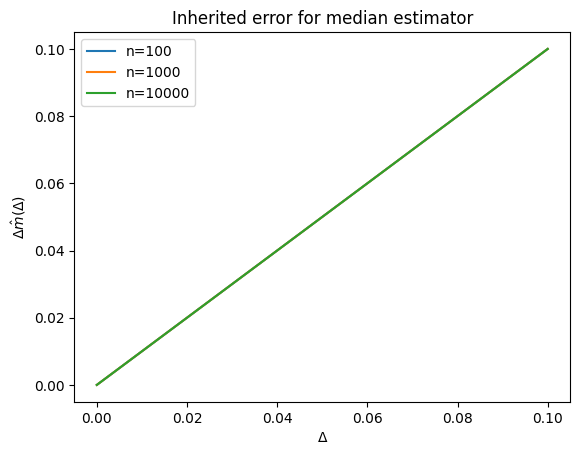

n=100: values = [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
n=1000: values = [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
n=10000: values = [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [10]:
rng = np.random.default_rng(123)

def median_hat(x: np.ndarray) -> float:
    x_sorted = np.sort(x)
    n = x_sorted.size
    if n % 2 == 1:
        return float(x_sorted[n // 2])
    return float(0.5 * (x_sorted[n // 2 - 1] + x_sorted[n // 2]))

def inherited_error_median(x: np.ndarray, Delta: float) -> float:
    base = median_hat(x)
    U = x + Delta
    L = x - Delta
    up = median_hat(U)
    down = median_hat(L)
    return max(abs(up - base), abs(down - base))

ns = [10**2, 10**3, 10**4]
deltas = np.round(np.arange(0.0, 0.10001, 0.01), 2)

results_med = {}
for n in ns:
    x = rng.uniform(0.0, 1.0, size=n)
    errs = [inherited_error_median(x, D) for D in deltas]
    results_med[n] = np.array(errs, dtype=float)

plt.figure()
for n in ns:
    plt.plot(deltas, results_med[n], label=f"n={n}")
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\Delta\hat m(\Delta)$')
plt.title(r'Inherited error for median estimator')
plt.legend()
plt.show()

for n in ns:
    print(f"n={n}: values =", np.round(results_med[n], 6))

# Итог для $\hat\mu$, $\hat\sigma^2$, $\hat m$

Рассматривалась модель погрешности исходных данных:
$$
x_i^{\text{obs}} = x_i + \delta_i,\qquad |\delta_i|\le \Delta,\qquad \Delta\in[0,0.1].
$$

Предел унаследованной погрешности для статистики $T(x)$ определён как
$$
\Delta T(\Delta)=\sup_{|\delta_i|\le \Delta}\left|T(x+\delta)-T(x)\right|.
$$

Оценки строились по выборкам из равномерного закона на $[0,1]$ при размерах
$$
n\in\{10^2,10^3,10^4\}.
$$

## Среднее
Для
$$
\hat\mu(x)=\frac{1}{n}\sum_{i=1}^n x_i
$$
получено аналитически и подтверждено численно:
$$
\Delta\hat\mu(\Delta)=\Delta.
$$
Графики для разных $n$ совпадают и дают прямую линию.

## Медиана
Для выборочной медианы $\hat m(x)$ использована монотонность функционала:
$$
\max \hat m(x+\delta)=\hat m(x+\Delta),\qquad \min \hat m(x+\delta)=\hat m(x-\Delta).
$$
В результате численно получено:
$$
\Delta\hat m(\Delta)=\Delta
$$
для всех рассмотренных $n$, то есть унаследованная погрешность медианы линейна и не зависит от размера выборки.

## Дисперсия
Для дисперсии
$$
\hat\sigma^2(x)=\frac{1}{n}\sum_{i=1}^n (x_i-\bar x)^2
$$
зависимость $\Delta\hat\sigma^2(\Delta)$ оказалась нелинейной, с ростом, близким к квадратичному по $\Delta$.
Вычисление выполнялось как максимум по ограниченному набору шаблонов возмущений, поэтому полученная величина является оценкой снизу для строгого супремума.


# Унаследованная погрешность для $A_s$ (асимметрия)

Используется коэффициент асимметрии:
$$
A_s(x)=\frac{m_3}{m_2^{3/2}},\qquad
m_r=\frac{1}{n}\sum_{i=1}^n (x_i-\bar x)^r.
$$

Для оценки унаследованной погрешности применяется случайный поиск по возмущениям:
$$
\delta_i\in\{-\Delta,+\Delta\},
$$
и вычисляется приближение
$$
\Delta A_s(\Delta)\approx \max_{j=1,\dots,N_{\text{trials}}}\left|A_s(x+\delta^{(j)})-A_s(x)\right|.
$$

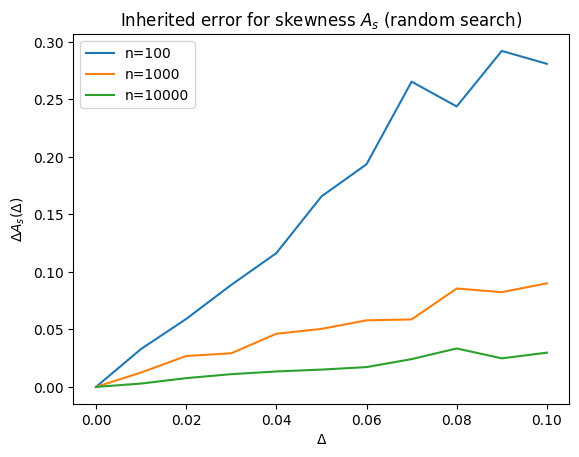

n=100: values = [0.       0.032993 0.059085 0.088733 0.116345 0.165632 0.193642 0.26548
 0.243907 0.292207 0.280991]
n=1000: values = [0.       0.012525 0.026868 0.029261 0.046226 0.050461 0.057917 0.058689
 0.085593 0.082426 0.090076]
n=10000: values = [0.       0.002923 0.007642 0.011091 0.013437 0.015066 0.017239 0.024175
 0.033453 0.024837 0.029803]


In [11]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def As_hat(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=np.float64)
    m = np.mean(x)
    z = x - m
    m2 = np.mean(z**2)
    m3 = np.mean(z**3)
    if m2 == 0.0:
        return 0.0
    return float(m3 / (m2 ** 1.5))

def inherited_error_As_random(x: np.ndarray, Delta: float, n_trials: int, rng: np.random.Generator) -> float:
    base = As_hat(x)
    n = x.size
    best = 0.0
    for _ in range(n_trials):
        signs = rng.choice([-1.0, 1.0], size=n)
        delta = Delta * signs
        val = As_hat(x + delta)
        diff = abs(val - base)
        if diff > best:
            best = diff
    return float(best)

ns = [10**2, 10**3, 10**4]
deltas = np.round(np.arange(0.0, 0.10001, 0.01), 2)

# число попыток можно увеличить, но для начала поставить умеренно
n_trials = 2000

results_As = {}
for n in ns:
    x = rng.uniform(0.0, 1.0, size=n)
    errs = [inherited_error_As_random(x, D, n_trials=n_trials, rng=rng) for D in deltas]
    results_As[n] = np.array(errs, dtype=float)

plt.figure()
for n in ns:
    plt.plot(deltas, results_As[n], label=f"n={n}")
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\Delta A_s(\Delta)$')
plt.title(r'Inherited error for skewness $A_s$ (random search)')
plt.legend()
plt.show()

for n in ns:
    print(f"n={n}: values =", np.round(results_As[n], 6))

# Вывод по $A_s$ и $E_x$

## $A_s$ (асимметрия)

Использовалась оценка асимметрии
$$
A_s(x)=\frac{m_3}{m_2^{3/2}},\qquad
m_r=\frac{1}{n}\sum_{i=1}^n (x_i-\bar x)^r.
$$

Унаследованная погрешность оценивалась методом случайного поиска по знаковым возмущениям
$$
\delta_i\in\{-\Delta,+\Delta\},
\qquad
\Delta A_s(\Delta)\approx \max_{j=1,\dots,N}\left|A_s(x+\delta^{(j)})-A_s(x)\right|.
$$

### Наблюдения по графику
1. $\Delta A_s(\Delta)$ растёт с увеличением $\Delta$ и имеет выраженную нелинейность; рост ближе к линейному на малых $\Delta$, затем заметно усиливается.
2. При увеличении размера выборки $n$ чувствительность $A_s$ к погрешности уменьшается:
$$
\Delta A_s(\Delta)\big|_{n=100} \;>\; \Delta A_s(\Delta)\big|_{n=1000} \;>\; \Delta A_s(\Delta)\big|_{n=10000}.
$$
3. Кривые не являются идеально монотонными (локальные провалы при $\Delta=0.08$–$0.10$ для $n=10000$).
Это ожидаемо, так как считается приближение супремума случайным поиском: для некоторых $\Delta$ мог не найтись близкий к оптимальному вектор знаков $\delta$.

### Интерпретация
Асимметрия содержит отношение центральных моментов, поэтому:
- малые изменения данных могут изменять и числитель $m_3$, и знаменатель $m_2^{3/2}$;
- итоговая чувствительность становится сильнее, чем у линейных функционалов (например, среднего);
- рост $n$ стабилизирует моменты и уменьшает вариативность итоговой оценки.

## $E_x$ (матожидание)

Для
$$
\hat E_x=\hat\mu=\frac{1}{n}\sum_{i=1}^n x_i
$$
строго получено:
$$
\Delta \hat E_x(\Delta)=\Delta.
$$